In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Add country names to country adjacency matrix:

In [2]:
country_names = pd.read_csv('../Data/RefugeeCountries.csv', header=None, names=['Country'])
country_adjacency = pd.read_csv('../Data/CountryAdjacencyNew.csv', header=None, names=country_names.Country)
country_adjacency.set_index(country_names.Country, inplace=True)
country_adjacency.head()

country_adjacency_without_names = pd.read_csv('../Data/CountryAdjacencyNew.csv', header=None)

In [3]:
country_adjacency.shape

(214, 214)

In [4]:
country_adjacency.Netherlands.sort_values(ascending=False).head(10)

Country
Nigeria                1.0
Madagascar             1.0
Marshall Islands       1.0
Malta                  1.0
Comoros                1.0
Congo - Brazzaville    1.0
Cook Islands           1.0
Malawi                 1.0
Costa Rica             1.0
Latvia                 1.0
Name: Netherlands, dtype: float64

In [5]:
def CalculateMetrics(G,Type):
    print(nx.info(G))
    weight =nx.is_weighted(G)
    print(weight)
    print('Link Density: '+str(nx.density(G)))

    num_nodes = G.number_of_nodes()
    print('Number of nodes: '+str(num_nodes))
    num_links = G.number_of_edges()
    print('Number of edges: '+str(num_links))

    all_links = G.edges()

    #print(all_links)

    degrees = [0]*(num_nodes + 1)

    if Type =="Language":
        for i in range(0,len(country_adjacency_without_names)):
            for j in range(0,len(country_adjacency_without_names)):
                if (i!=j):
                    degrees[i] += country_adjacency_without_names[i][j]

        degrees = degrees[1:]

        print('average degrees: ', np.mean(degrees))
        print('standard dev degrees: ', np.std(degrees))


    round_degrees = [int(x) for x in np.round(degrees)]
    degree_x = np.arange(1,max(round_degrees)+1)
    degree_y = [0]*(max(round_degrees))
    for i in range(max(round_degrees)):
      degree_y[i] = round_degrees.count(i+1)/num_nodes
    fig, ax = plt.subplots()
    ax.plot(degree_x, degree_y)
    ax.set(xlabel='degree k', ylabel='P[D=k]',
           title='Degree distribution for Language Data')
    ax.grid()
    plt.show()


    print("Clustering Coefficient: "+str(nx.average_clustering(G)))
    if Type!="Refugee":
        print("Average Hopcount: "+ str(nx.average_shortest_path_length(G)))
    
    #print("Betweenness: "+ str(nx.betweenness_centrality(G)))
    print("degree_cor: " + str(nx.degree_pearson_correlation_coefficient(G))) #means that i disassortative

    #print("Average Node Connectivity:"+str(nx.average_node_connectivity(G))) #very high since everythong is connected
    print("Edge Connectivity:"+str(nx.edge_connectivity(G)))

Create graph of language similarity between countries:

Name: Language similarity between countries
Type: Graph
Number of nodes: 214
Number of edges: 23002
Average degree: 214.9720
True
Link Density: 1.0092580404545655
Number of nodes: 214
Number of edges: 23002
average degrees:  76.68501824545886
standard dev degrees:  40.53924609131826


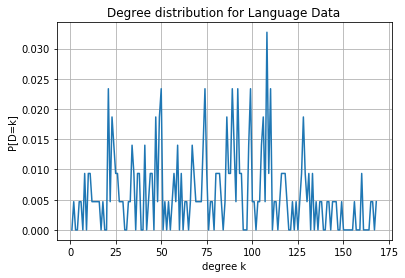

Clustering Coefficient: 0.9998687673045364


In [ ]:
G = nx.from_pandas_adjacency(country_adjacency.T)
G.name = 'Language similarity between countries'
CalculateMetrics(G,"Language")

In [ ]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.show()

Read one year of refugee data, rows denote country of asylum, columns denote country of origin.

In [ ]:
refugee_data_folder = '../Data/RefugeeMatrices/'
years =range(2010,2017)
refugeeMatrices =dict()
for i in years:
    yearMatrix = pd.read_csv(refugee_data_folder + 'RefugeeAdjacency'+str(i)+'.csv', 
                           header=None, names=country_names.Country, dtype=int)
    yearMatrix.set_index(country_names.Country, inplace=True)
    yearMatrix.head()
    refugeeMatrices[str(i)]=yearMatrix

In [8]:
refugee_2016=refugeeMatrices['2016']
refugee_2016.shape

(214, 214)

Convert refugee adjacency matrix to percentage refugees of origin country:

In [9]:
refugee_2016 = refugee_2016.div(refugee_2016.sum(axis=0), axis=1)
refugee_2016.fillna(0, inplace=True)
refugee_2016.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua & Barbuda,Argentina,Armenia,Aruba,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000e+00,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Albania,0.000000e+00,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000107,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Algeria,8.035223e-07,0.0,0.00000,0.0,0.000035,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.992764,0.000052,0.000000,0.0
Andorra,0.000000e+00,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Angola,0.000000e+00,0.0,0.00026,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000199,0.000000,0.004645,0.0


Create directed graph with networkx from adjacency df.
Transpose df because networkx uses rows as source nodes and columns as target nodes.
Remove nodes that have less refugees than certain threshold and create two graphs of language similarity and refugees.

In [10]:
threshold = 0.9
refugee_2016_masked = refugee_2016.mask(refugee_2016 < threshold, 0)

In [11]:
G2016 = nx.from_pandas_adjacency(refugee_2016_masked.T, create_using=nx.DiGraph())
G2016.name = 'Refugee 2016'
CalculateMetrics(G2016,"Refugee")

Name: Refugee 2016
Type: DiGraph
Number of nodes: 214
Number of edges: 26
Average in degree:   0.1215
Average out degree:   0.1215


In [12]:
nodes_to_remove = list(nx.isolates(G2016))
G2016.remove_nodes_from(nodes_to_remove)
print(nx.info(G2016))

Name: Refugee 2016
Type: DiGraph
Number of nodes: 40
Number of edges: 26
Average in degree:   0.6500
Average out degree:   0.6500


In [13]:
G.remove_nodes_from(nodes_to_remove)
print(nx.info(G))

Name: Language similarity between countries
Type: Graph
Number of nodes: 40
Number of edges: 820
Average degree:  41.0000


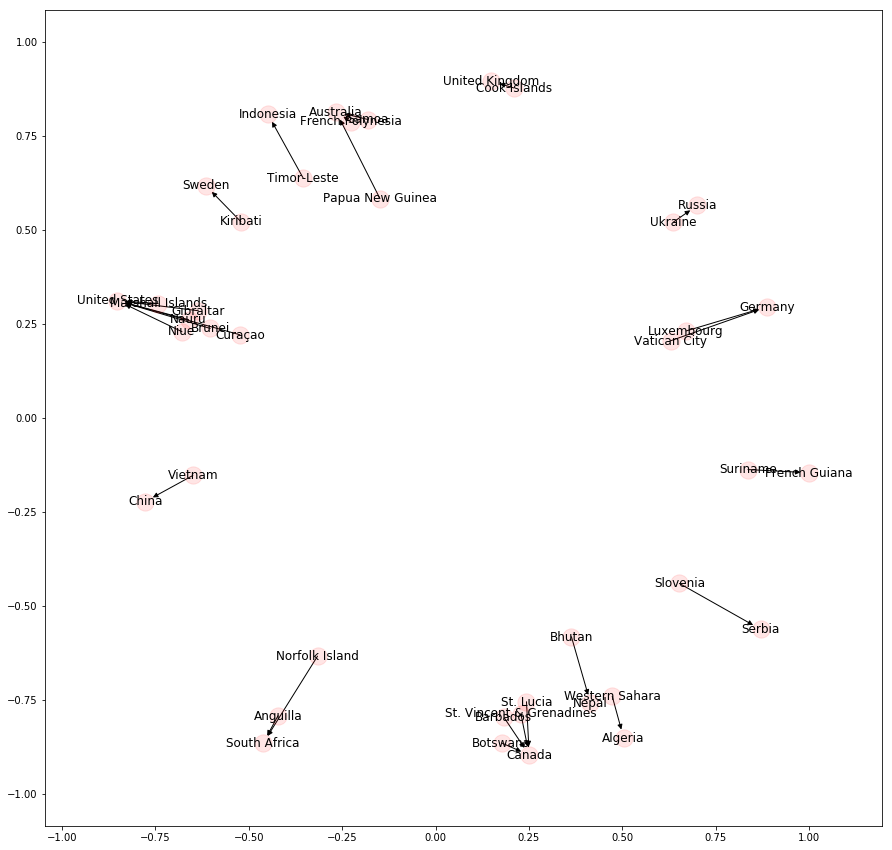

In [14]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G2016)
nx.draw_networkx_nodes(G2016, pos, alpha=0.1)
nx.draw_networkx_labels(G2016, pos)
nx.draw_networkx_edges(G2016, pos)
plt.show()

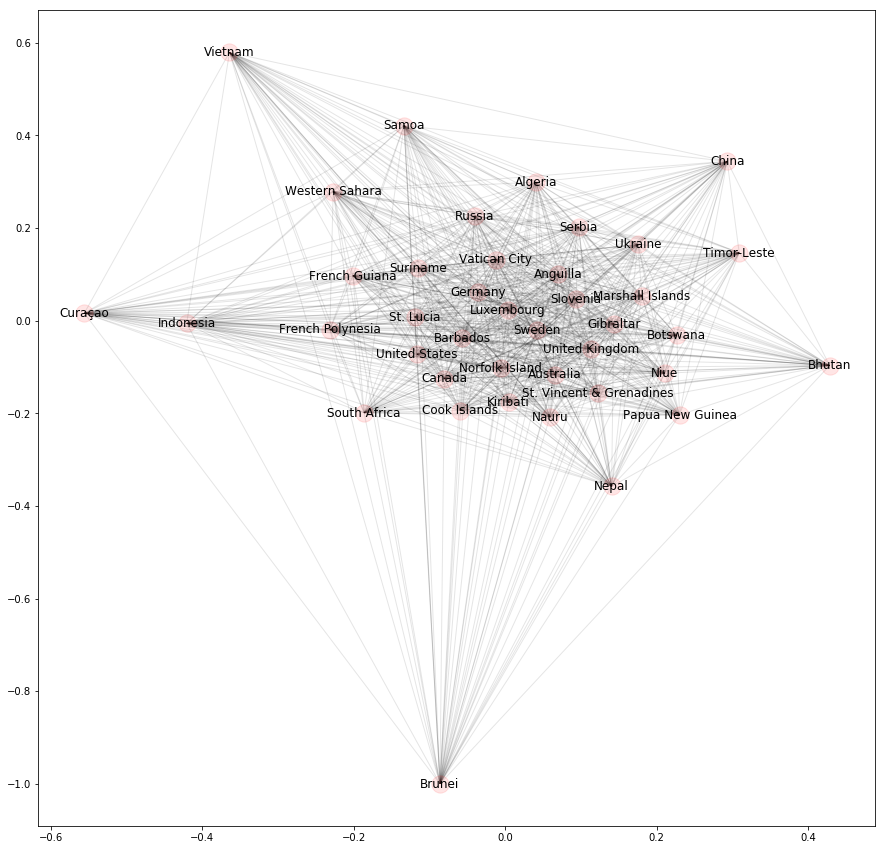

In [15]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.show()